In [1]:
# This code below is to se the structure of the code for Pyramidal Neuron - Larkum style
# Learning through target spikes

import numpy as np

from lttb import LTTB

import matplotlib.pyplot as plt

from tqdm import trange
import random


N, I, O, T = 500, 40, 3, 500
shape = (N, I, O, T)

dt = .001
tau_m = 20. * dt
tau_s = 2. * dt
tau_ro = 10. * dt
tau_star = 20. * dt
tau_W = 200 * dt

beta = np.exp(-dt/tau_s)
beta_ro = np.exp(-dt/tau_ro)
beta_targ = np.exp(-dt/tau_star)
beta_W = np.exp(-dt/tau_W)

sigma_targ = 10**.8
sigma_in = 12.

dv = 1 / 500.
alpha = .005
alpha_rout = .01
Vo = - 4
h = - 1
s_inh = 20

sigma_Jrec = 5.
sigma_wrec = 0.
sigma_Jout = 0.1
sigma_context = 0.

Ne = 400
Ni = 100

N = Ne+Ni

n_contexts = 2

# Here we build the dictionary of the simulation parameters
par = {'dt' : dt, 'tau_m' : tau_m, 'tau_s' : tau_s, 'tau_ro' : tau_ro, 'tau_star' : tau_star,'tau_W' : tau_W,
       'dv' : dv, 'Vo' : Vo, 'h' : h, 's_inh' : s_inh,
       'N' : N, 'Ni' : Ni, 'Ne' : Ne, 'T' : T, 'I' : I, 'O' : O, 'shape' : shape, 
       'sigma_Jrec' : sigma_Jrec,'sigma_wrec' : sigma_wrec, 'sigma_Jout' : sigma_Jout, 'n_contexts' : n_contexts,
       'alpha' : alpha, 'alpha_rout' : alpha_rout,'sigma_context' : sigma_context,
       'sigma_in' : sigma_in, 'sigma_targ' : sigma_targ, 'h' : h}

TIME = 1.

T = int(np.floor(TIME/dt))

nStepOutTraining = 1000

t_shut = 10

JMAX = 100.
nu_targ = 0.005


# Here we init our (recurrent) agent
lttb = LTTB (par)


In [2]:
jp = lttb.j_in
jm = lttb.j_in

threshold = 12

jp = np.heaviside(jp-threshold,0)*20
jm = np.heaviside(-(jm- (-threshold)),0)*-20

lttb.j_in = jp+jm

In [3]:
lttb.j_in

array([[  0.,   0.,  20., ..., -20.,  20.,  20.],
       [ 20., -20., -20., ..., -20.,   0.,   0.],
       [  0.,   0.,   0., ...,  20.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ..., -20.,   0.,   0.],
       [ 20.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,  20., ...,   0.,   0.,   0.]])

(array([ 3088.,     0.,     0.,     0.,     0., 13796.,     0.,     0.,
            0.,  3116.]),
 array([-20., -16., -12.,  -8.,  -4.,   0.,   4.,   8.,  12.,  16.,  20.]),
 <BarContainer object of 10 artists>)

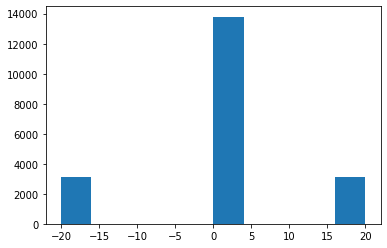

In [4]:
plt.hist(lttb.j_in.flatten() )

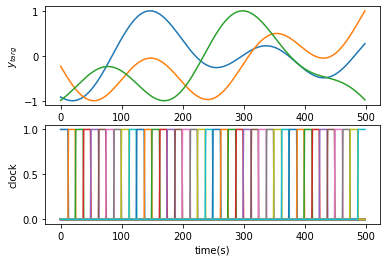

In [5]:
# define clock and target

lttb.init_targ(par)
lttb.init_clock(par)

plt.figure()
plt.subplot(211)
plt.plot(np.array(lttb.y_targ).T)
plt.ylabel('$y_{targ}$')
plt.subplot(212)
plt.plot(np.array(lttb.I_clock).T)
plt.xlabel('time(s)')
plt.ylabel('clock')
plt.show()


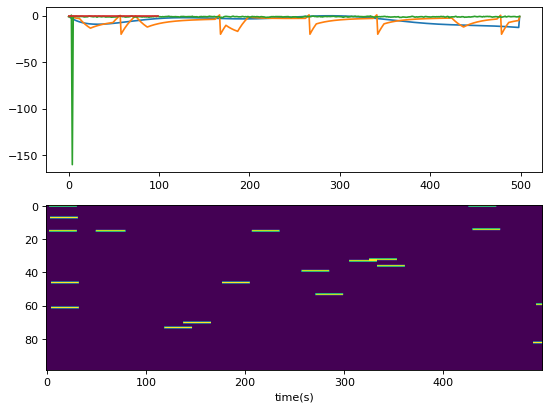

In [6]:
#initialize simulation

lttb.initialize(par)

#run simulation

for t in range(lttb.T-2):
    lttb.step(apicalFactor=1.)

#save target
S_apic_targ = lttb.S_apic_dist
B_targ = lttb.B_filt
W_targ = lttb.S_wind_targ
    
ndx_plot = random.randint(0,lttb.N)

#plt.imshow(lttb.Vapic)
plt.figure(figsize=(8, 6), dpi=80)

plt.subplot(211)

plt.plot(lttb.Vapic[ndx_plot,0:500])
plt.plot(lttb.Vsoma[ndx_plot,0:500])
plt.plot(lttb.VapicRec[ndx_plot,0:500])

#plt.plot(lttb.S_soma[ndx_plot,:]*50)
#plt.plot(lttb.S_wind[ndx_plot,:]*100)
plt.plot(lttb.B_filt[ndx_plot,0:100]*250)

plt.subplot(212)
#plt.imshow(1-lttb.S_wind[1:50,:],aspect = 'auto',cmap='gray')
plt.imshow(lttb.S_wind_targ[1:100,:],aspect = 'auto')
#plt.imshow(lttb.S_soma[1:25,:],aspect = 'auto')
plt.xlabel('time(s)')

plt.show()

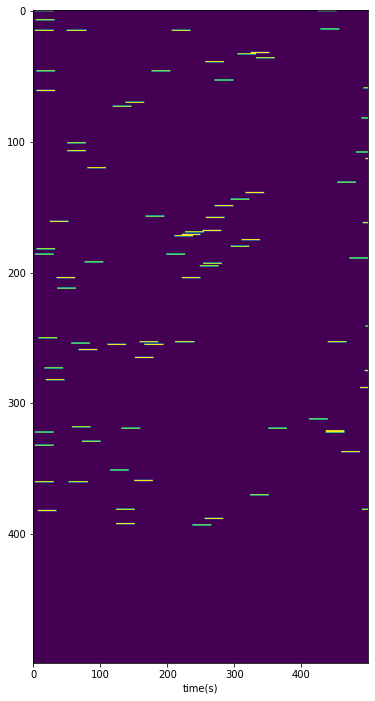

In [7]:
plt.figure(figsize=(6, 12))


#plt.imshow(1-lttb.S_wind[1:50,:],aspect = 'auto',cmap='gray')
plt.imshow(lttb.S_wind_targ[1:500,:],aspect = 'auto')
#plt.imshow(lttb.S_soma[1:25,:],aspect = 'auto')
plt.xlabel('time(s)')

plt.show()

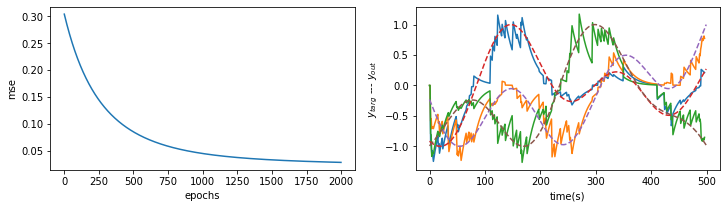

In [8]:
## Training RO

mse, Y = lttb.train_ro(par,out_epochs = 2000)

plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(mse)
plt.xlabel('epochs')
plt.ylabel('mse')

plt.subplot(122)
plt.plot(Y.T)
plt.plot(lttb.y_targ.T,'--')
plt.xlabel('time(s)')
plt.ylabel('$y_{targ}$ --- $y_{out}$')
plt.show()



In [9]:
## Training Rec

gamma = 10.

def f(x,gamma):
    return np.exp(x*gamma)/(np.exp(x*gamma)+1)
#f1 = @(x)(gamma*exp(gamma*x))./(exp(gamma*x)+1)-(gamma*exp(2*gamma*x))./(exp(gamma*x)+1).^2;

apicalFactorTrain = 1
apicalFactorTest = 0

nIterRec = 10

eta_out = 0.05
eta = 40.*5.*1.5*2.
dw = 0.
eta_w = .0

mse = []
errors = []
ifplot=0
for iter in range(nIterRec):
    
    ###### Online-Training

    #initialize simulation

    lttb.initialize(par)

    #run simulation
    dH = 0
    DJ_cum=0
    
    factor = .1
    
    if iter==2:
        eta/=3.

    for t in range(lttb.T-2):
        
        lttb.step(apicalFactor = apicalFactorTrain)
        
        dH = dH*(1-dt/tau_m) + dt/tau_m*lttb.S_filt[:,t]
        #DJ = .2*np.outer(( lttb.B_filt[:,t+1] - lttb.B_filt_rec[:,t+1] ) ,dH)
        #DJ = np.outer(( S_apic_targ[:,t+1] - f(lttb.VapicRec[:,t],gamma) )*(1-S_apic_targ[:,t]) ,dH)
        DJ = np.outer(( lttb.S_apic_dist[:,t+1] - f(lttb.VapicRec[:,t],gamma) )*f(lttb.VapicRec[:,t],1)*(1-f(lttb.VapicRec[:,t],1))*(1-lttb.S_apic_dist[:,t]) ,dH)
        #DJ = np.outer(( lttb.S_apic_dist[:,t+1] - f(lttb.VapicRec[:,t],gamma) )*(1-lttb.S_apic_dist[:,t]) ,dH)
        DJ_cum = DJ_cum + DJ
        
        dw = np.outer(( lttb.S_apic_dist[:,t+1] - f(lttb.VapicRec[:,t],gamma) )*(1-lttb.S_apic_dist[:,t]) ,dH)
        
        DJ_mod = np.abs(DJ)
        DJ_sig = np.sign(DJ)
        DJ_update = np.minimum( DJ_mod, np.abs(lttb.J) * factor)*DJ_sig
        
        #lttb.J = np.maximum(lttb.J,-10)
        #lttb.J = np.minimum(lttb.J,10)
        
        #SR = [:,1:-2]
        SR = lttb.B_filt_rec[:,t+1]
        Y = lttb.Jout@SR
        DJRO = np.outer(lttb.y_targ[:,t+1] - Y,SR.T)
        
        if iter>0:
            lttb.J =  lttb.J + eta*DJ#np.maximum(DJ,0)#
            
            lttb.w = lttb.w + eta_w*dw#np.minimum(dw,0)#eta_w*dw# 
            lttb.Jout =  lttb.Jout + eta_out*DJRO
            
            #lttb.w = np.minimum(lttb.w,0)
            #lttb.J = np.maximum(lttb.J,0)
            
            np.fill_diagonal (lttb.J, 0.)
            np.fill_diagonal (lttb.w, 0.)
    
    #print(DJ)
    
        
    ###### Test
    
    lttb.initialize(par)

    #run simulation

    for t in range(lttb.T-2):
        
        lttb.step(apicalFactor = apicalFactorTest)
        
    SR = lttb.B_filt_rec[:,1:-2]
    Y = lttb.Jout@SR
    mse_rec_train = np.std(lttb.y_targ[:,1:-2] - Y)**2
    print(np.sum(np.abs(W_targ*lttb.S_wind_pred)))
    errors.append(np.sum(np.abs(W_targ*lttb.S_wind_pred))/np.sum(np.abs(W_targ)) )
    mse.append(mse_rec_train)

    print(mse_rec_train)
    
    if ifplot:
        plt.subplot(311)
        plt.hist(DJ_cum.reshape(len(DJ_cum)*len(DJ_cum[0])))
        plt.title("iteration " + str(iter))
        plt.subplot(312)
        #plt.imshow(lttb.S_wind_targ)
        plt.imshow(lttb.S_wind_pred[0:100,:],aspect= 'auto')

        plt.subplot(313)
        plt.imshow(W_targ[0:100,:],aspect= 'auto')
        plt.show()

        #plt.hist( histmat = np.log(np.abs(DJ_cum))- np.log(np.abs(lttb.J)) )
        plt.show()
    
    
    #mse, Y = lttb.train_ro(par,out_epochs = 1)




0.0
0.30659740412408554
738.0
0.3318118731594717
1052.0
0.09284373979027626
1115.0
0.08412199827941097
1289.0
0.08495618248506345
1372.0
0.13404769670744834
1349.0
0.09585922074290003
1262.0
0.08023609791600948
1259.0
0.0785292792361402
1229.0
0.09449969591929613


<Figure size 432x288 with 0 Axes>

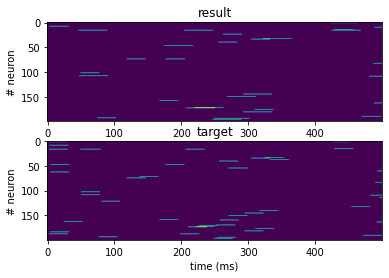

In [10]:
plt.figure()
plt.figure()
plt.subplot(211)
#plt.imshow(lttb.S_wind_targ)
plt.imshow(lttb.S_wind_pred[0:200,:],aspect= 'auto')
plt.title('result')
plt.ylabel('# neuron')
plt.subplot(212)
plt.title('target')
plt.imshow(W_targ[0:200,:],aspect= 'auto')
plt.ylabel('# neuron')
plt.xlabel('time (ms)')
plt.show()



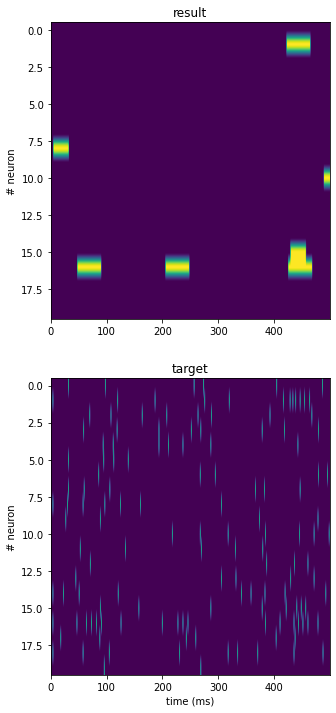

In [19]:
plt.figure(figsize=(5,12))
plt.subplot(211)
#plt.imshow(lttb.S_wind_targ)
plt.imshow(lttb.S_wind_pred[0:20,:],aspect= 'auto')
plt.title('result')
plt.ylabel('# neuron')
plt.subplot(212)
plt.title('target')
plt.imshow(lttb.S_soma[0:20,:],aspect= 'auto')
plt.ylabel('# neuron')
plt.xlabel('time (ms)')
plt.show()

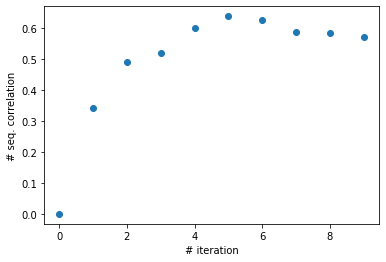

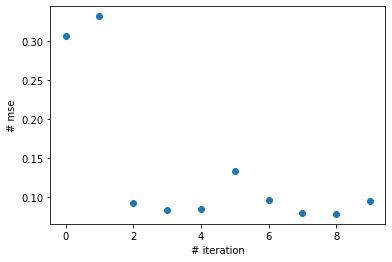

In [12]:
plt.figure()
plt.plot(errors,'o')
plt.ylabel('# seq. correlation')
plt.xlabel('# iteration')

plt.show()

plt.figure()
plt.plot(mse,'o')

plt.ylabel('# mse')
plt.xlabel('# iteration')

plt.show()


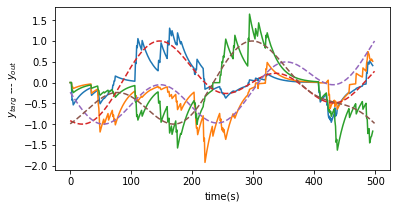

In [14]:
plt.figure(figsize=(6, 3))
plt.plot(Y.T)
plt.plot(lttb.y_targ.T,'--')
plt.xlabel('time(s)')
plt.ylabel('$y_{targ}$ --- $y_{out}$')
plt.show()


0.060389182970515515


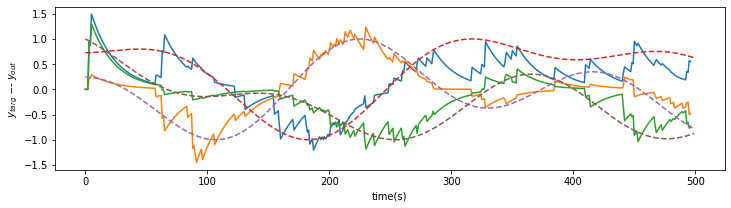

In [22]:
 ###### Test
    
#lttb.J = lttb.J *0
    
lttb.initialize(par)

    #run simulation

for t in range(lttb.T-2):
        
    lttb.step(apicalFactor = 0)
        
SR = (lttb.B_filt_rec[:,1:-2]+lttb.B_filt[:,1:-2])
Y = lttb.Jout@SR
mse_rec_train = np.std(lttb.y_targ[:,1:-2] - Y)**2

print(mse_rec_train)
    
#mse, Y = lttb.train_ro(par,out_epochs = 1)

plt.figure(figsize=(12, 3))
plt.plot(Y.T)
plt.plot(lttb.y_targ.T,'--')
plt.xlabel('time(s)')
plt.ylabel('$y_{targ}$ --- $y_{out}$')
plt.show()

